In [1]:
import pandas as pd
df = pd.read_csv(filepath_or_buffer='/kaggle/input/shipwrecks-sunk-ships/Shipwrecks or Sunk ships.csv', parse_dates=['Sunk date'], 
                encoding='utf-8', encoding_errors='replace')
df.head()

,Ship,Flag,Sunk date,Notes,Coordinates
0,Black Assarca shipwreck,Unknown,Early 7th century (Presumed),A wreck discovered at Black Assarca Island in ...,NaN
1,Globe Star,Singapore,27-Apr-73,A cargo ship that ran aground off Mombasa.[1],4°04′54″S 39°43′12″E
2,Gulland,Aden,13-Apr-51,A 545-ton Isles-class trawler built for World ...,04°02′50″S 39°43′57″E
3,Mtongwe,Tanzania,27-Apr-94,A Likoni and Mombasa route ferry that capsized...,NaN
4,Katina P,Greece,26-Apr-92,"An oil tanker that was damaged in a storm, spi...",25°35′S 32°59′E


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3971 entries, 0 to 3970
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Ship         3952 non-null   object
 1   Flag         3202 non-null   object
 2   Sunk date    3573 non-null   object
 3   Notes        3914 non-null   object
 4   Coordinates  1019 non-null   object
dtypes: object(5)
memory usage: 155.2+ KB


<Axes: ylabel='Frequency'>

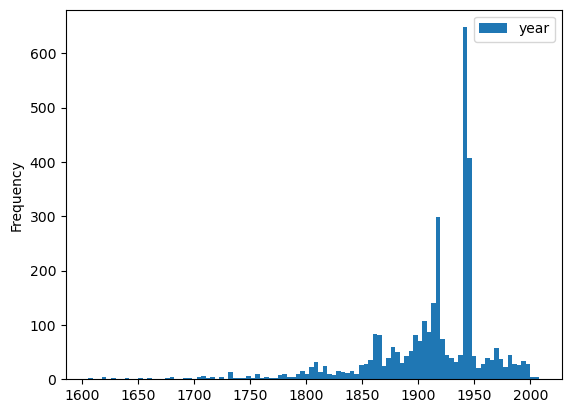

In [3]:
from numpy import nan
def get_year(arg) -> float:
    if isinstance(arg, float):
        return arg
    if isinstance(arg, str):
        if arg.isnumeric():
            return int(arg)
    pieces = arg.split('-')
    if pieces[-1].isnumeric():
        return 1900 + int(pieces[-1])
    pieces = arg.split()
    if pieces[-1].isnumeric():
        return int(pieces[-1])
    return nan
df['year'] = df['Sunk date'].apply(get_year)
# we can cut off the left tail of the histogram and not lose any story
df[df['year'] > 1600][['year']].plot.hist(bins=100)

Are we shocked that they cluster around World War II? We are not.

What percentage of cases have something possibly useful in the Sunk date column but we don't yet know the year?

In [4]:
100 * round(len(df[(df['year'].isna()) & (df['Sunk date'] != 'Unknown')])/len(df), 2)

12.0

In [5]:
df['Coordinates'].head()

0                      NaN
1     4°04′54″S 39°43′12″E
2    04°02′50″S 39°43′57″E
3                      NaN
4          25°35′S 32°59′E
Name: Coordinates, dtype: object

In [6]:
# remove special cases and extra coordinates
def drop_extras(arg):
    if isinstance(arg, float):
        return nan
    if arg in {'E', 'An E'}:
        return nan
    if not isinstance(arg, str):
        return nan
    arg = arg.split('/')[0]
    return arg

df['Coordinates'] = df['Coordinates'].apply(func=drop_extras)

df[df['Coordinates'].notnull()][['Coordinates']].sample(n=5)
# this data is kind of messy; we'll need to do further work before we can make a map

,Coordinates
769,51°12′N 2°10′E
391,57°27′N 10°40′E
445,37°42′05″N 24°17′02″E
3408,28°43′40″S 113°42′20″E
3694,40°26′35″N 017°15′06″E


In [7]:
# we need to map non-ASCII primes and double-primes into ASCII single and double quotes
# and for some reason our data contains a non-ASCII W
char_map = {8242: 39, 8243: 34, 65279: 87}
def fix_domain(arg):
    if isinstance(arg, float): 
        return arg
    arg = [ord(char) for char in list(arg)]
    arg = [char if char not in char_map.keys() else char_map[char] for char in arg]
    result = ''.join([chr(char) for char in arg])
    return result.replace('WW', 'W')

df['Coordinates'] = df['Coordinates'].apply(func=fix_domain)
df[df['Coordinates'].notnull()].sample(n=5)

,Ship,Flag,Sunk date,Notes,Coordinates,year
3142,Yūdachi,Imperial Japanese Navy,13-Nov-42,A Japanese Shiratsuyu-class destroyer that was...,09°14'S 159°52'E,1942.0
70,Oceanos,Greece,4-Aug-91,A cruise liner that sank off the Transkei coas...,"32°07'15""S 29°07'13""E",1991.0
3820,Adolf Vinnen,Kriegsmarine,23-Oct-40,A weather ship that was sunk by British ships ...,62°29'N 4°23'E,1940.0
18,HMS Ibis,Royal Navy,10-Nov-42,A Black Swan-class sloop that was sunk by an I...,37°0'N 3°0'E,1942.0
3389,Loch Ard,NaN,1 June 1878,Struck Mutton Bird Island.,"38°38'55""S 143°04'19""E",1878.0


In [8]:
# now we can split our coordinates into latitude and longitude
def get_coord(arg, index):
    if not isinstance(arg, str):
        return arg
    pieces = arg.split()
    return pieces[index].strip()

df['latitude_str'] = df['Coordinates'].apply(func=get_coord, args=(0, ))
df['longitude_str'] = df['Coordinates'].apply(func=get_coord, args=(1, ))
df[df['Coordinates'].notnull()].sample(n=5)

,Ship,Flag,Sunk date,Notes,Coordinates,year,latitude_str,longitude_str
387,HMS Defence,Royal Navy,24 December 1811,A 74-gun third-rate ship of the line that stra...,"56°21'30""N 8°06'00""E",1811.0,"56°21'30""N","8°06'00""E"
3101,Ayanami,Imperial Japanese Navy,15-Nov-42,A Japanese Fubuki-class destroyer that was sun...,9°10'S 159°52'E,1942.0,9°10'S,159°52'E
299,USS Lanakai,United States Navy,1947,A schooner-rigged diesel yacht that was confis...,14°46'N 120°15'E,1947.0,14°46'N,120°15'E
3441,Rapid,United States,7 January 1811,An American China trader wrecked at Ningaloo R...,"22°44'22""S 113°41'34""E",1811.0,"22°44'22""S","113°41'34""E"
1592,USS Eagle Boat 56,United States Navy,23-Apr-45,An Eagle-class patrol boat that was sunk by U-...,"43°33'28""N 70°09'44""W",1945.0,"43°33'28""N","70°09'44""W"


In [9]:
from numpy import nan
def get_dd(arg) -> float:
    if not isinstance(arg, str):
        return arg
    direction = arg[-1]
    multiplier = -1 if direction in {'S', 'W'} else 1
    pieces = arg[:-1].replace('°', ' ').replace('\'', ' ').replace('\"', ' ').split()
    return multiplier * sum([float(piece)/pow(60, index) for index, piece in enumerate(pieces)])

df['latitude'] = df['latitude_str'].apply(func=get_dd)
df['longitude'] = df['longitude_str'].apply(func=get_dd)
df = df.drop(columns=['latitude_str', 'longitude_str'])
df[df['Coordinates'].notnull()].sample(n=5)

,Ship,Flag,Sunk date,Notes,Coordinates,year,latitude,longitude
3460,Zeewijk,NaN,9 June 1727,Dutch VOC merchant sailing ship.,"28°54'30""S 113°49'0""E",1727.0,-28.908333,113.816667
102,Wafra,Liberia,28-Feb-71,"An oil tanker that grounded near Cape Agulhas,...",36°57'S 20°42'E,1971.0,-36.950000,20.700000
3546,Portugal,Imperial Russian Navy,30-Mar-16,A Russian hospital ship that was torpedoed by ...,"42°00'36""N 41°11'24""E",1916.0,42.010000,41.190000
1035,UB-56,Imperial German Navy,19-Dec-17,A Type UB III U-boat that was sunk by a mine.,50°58'N 01°21'E,1917.0,50.966667,1.350000
3902,SS Hoihow,United Kingdom,2-Jul-43,A passenger ship that was torpedoed by U-181.[5],19°30'S 55°30'E,1943.0,-19.500000,55.500000


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<Axes: xlabel='longitude', ylabel='latitude'>

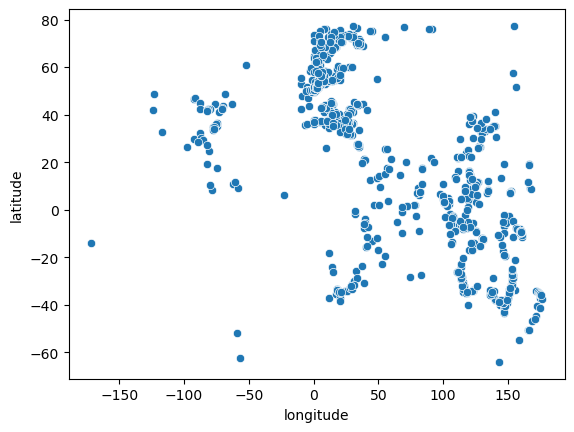

In [10]:
# now we can make a scatter plot
from seaborn import scatterplot
scatterplot(data=df[df['Coordinates'].notnull()], x='longitude', y='latitude')

This is kind of encouraging, as we can kind if see the outlines of some familiar features in the scatter plot. But this data would look better on a map.